# Finite State Worlds

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator 

from lcs.agents import EnvironmentAdapter
from lcs import Perception

import gym
import gym_fsw

# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

In [2]:
# Import utils functions
%run utils/experiments.py
%run utils/metrics.py
%run utils/plots.py
%run utils/payoff_landscape.py
%run utils/basic_rl.py

## Environment setup

In [3]:
env = gym.make('fsw-10-v0')

In [4]:
class FSWAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        return phenotype,

## Basic Metrics
Examine population size, rho parameter and exploitation capabilities.

In [5]:
# Params
learning_rate = 0.1
discount_factor = 0.95
epsilon = 0.1
zeta = 0.0001

# Set ACS2/AACS2 configuration parameter dictionary
basic_cfg = {
    'perception_bits': 1,
    'possible_actions': 2,
    'do_ga': False,
    'beta': learning_rate,
    'epsilon': 1-epsilon,
    'gamma': discount_factor,
    'zeta': zeta,
    'environment_adapter': FSWAdapter,
    'user_metrics_collector_fcn': common_metrics,
    'biased_exploration_prob': 0,
    'metrics_trial_freq': 1
}

In [6]:
%%time

agg_df = avg_experiments(3, trials=5_000, env=env, params=basic_cfg)

Executing experiment 0
Executing experiment 1
Executing experiment 2
CPU times: user 1min 31s, sys: 525 ms, total: 1min 31s
Wall time: 1min 33s


In [7]:
agg_df

phase  steps_in_trial       rho  population  reliable
agent    trial                                                         
AACS2_v1 0      explore       15.666667  0.000000   15.666667       0.0
         1      exploit       15.666667  0.010000   15.666667       0.0
         2      explore       14.333333  0.009999   21.666667       0.0
         3      exploit       14.666667  0.019985   21.666667       0.0
         4      explore       15.000000  0.019980   27.000000       0.0
...                 ...             ...       ...         ...       ...
ACS2     4995   exploit       10.000000  0.000000   40.000000      40.0
         4996   explore       14.333333  0.000000   40.000000      40.0
         4997   exploit       10.000000  0.000000   40.000000      40.0
         4998   explore       13.333333  0.000000   40.000000      40.0
         4999   exploit       10.000000  0.000000   40.000000      40.0

[15000 rows x 5 columns]

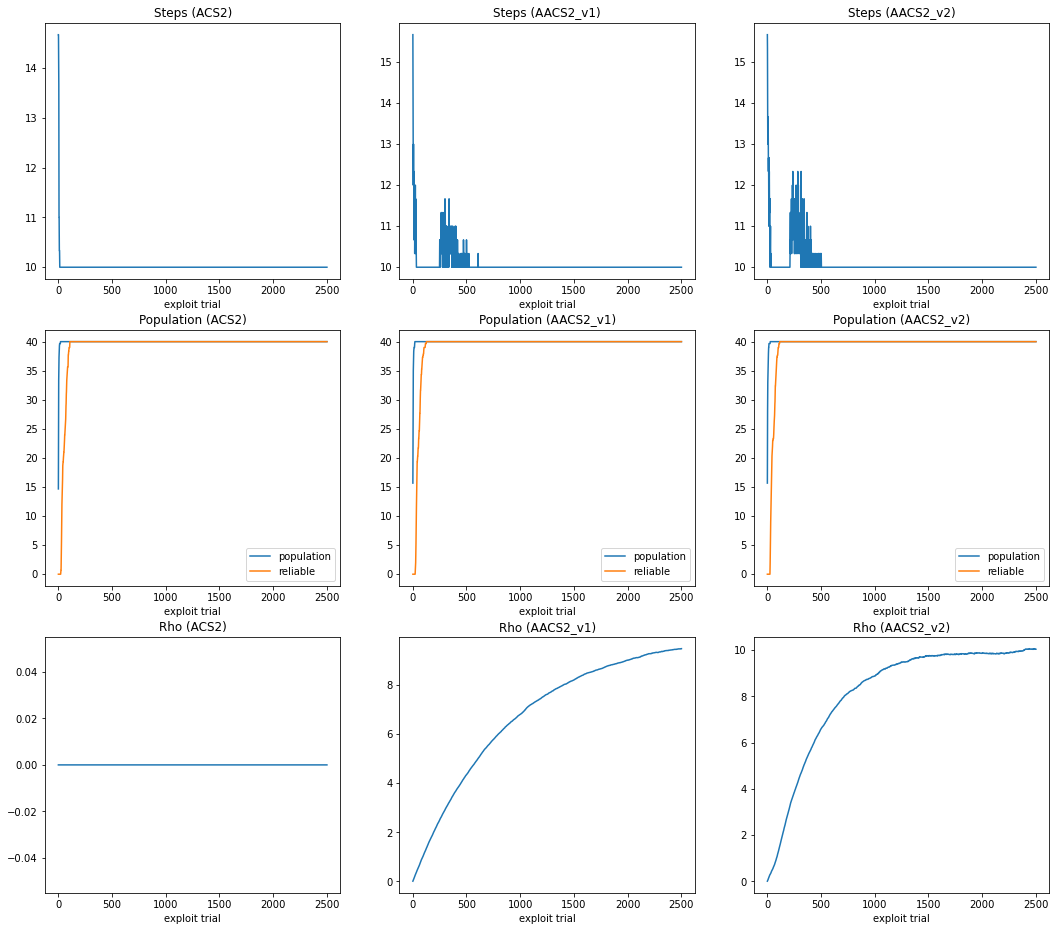

In [8]:
plot_exploit_results(agg_df)

## Payoff Landscape

In [9]:
state_action = get_all_state_action(env._state_action())
state_action[:10]

[StateAction(id=1, state='0', action=0),
 StateAction(id=2, state='0', action=1),
 StateAction(id=3, state='1', action=0),
 StateAction(id=4, state='1', action=1),
 StateAction(id=5, state='2', action=0),
 StateAction(id=6, state='2', action=1),
 StateAction(id=7, state='3', action=0),
 StateAction(id=8, state='3', action=1),
 StateAction(id=9, state='4', action=0),
 StateAction(id=10, state='4', action=1)]

### Data preparation

In [10]:
%%time

pop_acs2, pop_aacs2v1, pop_aacs2v2, _ = run_experiments(env, 5_000, basic_cfg)

CPU times: user 31.7 s, sys: 241 ms, total: 32 s
Wall time: 32.9 s


#### Q-learning

In [11]:
%%time

Q_init = np.zeros((env.observation_space.n, env.action_space.n))
Q = qlearning(env, 10_000, Q_init, epsilon, learning_rate, discount_factor)

CPU times: user 1.56 s, sys: 18 ms, total: 1.58 s
Wall time: 1.67 s


#### R-learning

In [12]:
%%time

R_init = np.zeros((env.observation_space.n, env.action_space.n))
R, rho = rlearning(env, 10_000, R_init, epsilon, learning_rate, zeta)

CPU times: user 2.32 s, sys: 34.1 ms, total: 2.35 s
Wall time: 2.42 s


In [13]:
rho

9.639402279913922

### Landscape plot

In [14]:
payoffs = {}

for sa in state_action:
    p = Perception((sa.state,))

    # ACS2
    acs2_match_set = pop_acs2.form_match_set(p)
    acs2_action_set = acs2_match_set.form_action_set(sa.action)

    # AACS2_v1
    aacs2v1_match_set = pop_aacs2v1.form_match_set(p)
    aacs2v1_action_set = aacs2v1_match_set.form_action_set(sa.action)

    # AACS2_v2
    aacs2v2_match_set = pop_aacs2v2.form_match_set(p)
    aacs2v2_action_set = aacs2v2_match_set.form_action_set(sa.action)

    # Check if all states are covered
    for alg, action_set in zip(['ACS2', 'AACS2_v1', 'AACS2_v2'],
                               [acs2_action_set, aacs2v1_action_set,
                                aacs2v2_action_set]):
        if len(action_set) == 0:
            print(f"WARN: No {alg} classifiers for perception: {sa.perception}, action: {sa.action}")

    payoffs[sa] = {
        'acs2': np.mean(list(map(lambda cl: cl.r, acs2_action_set))),
        'aacs2-v1': np.mean(list(map(lambda cl: cl.r, aacs2v1_action_set))),
        'aacs2-v2': np.mean(list(map(lambda cl: cl.r, aacs2v2_action_set))),
        'q-learning': Q[int(sa.state), sa.action],
        'r-learning': R[int(sa.state), sa.action]
    }

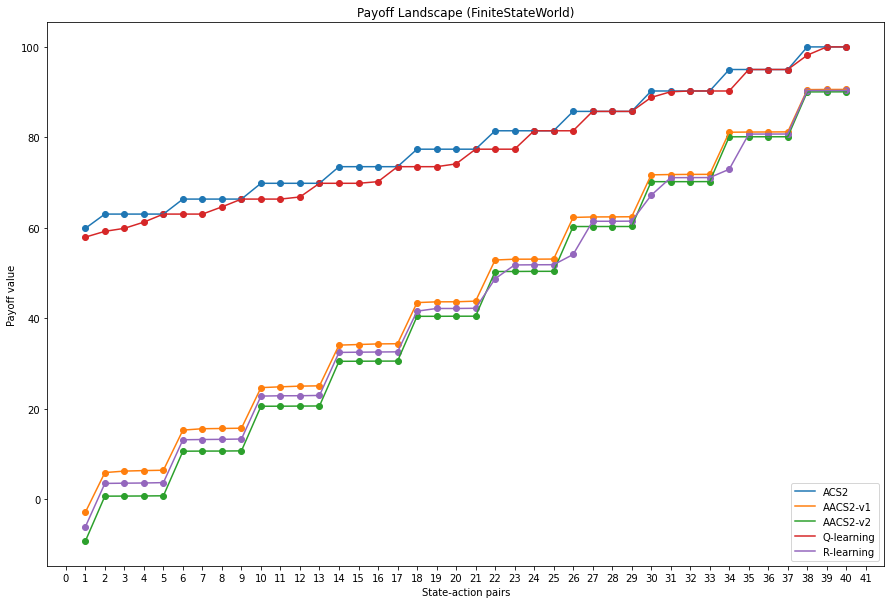

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))

x = range(1, len(payoffs)+1)
y_acs2 = sorted([v['acs2'] for k, v in payoffs.items()])
y_aacs2v1 = sorted([v['aacs2-v1'] for k, v in payoffs.items()])
y_aacs2v2 = sorted([v['aacs2-v2'] for k, v in payoffs.items()])
y_qlearning = sorted([v['q-learning'] for k, v in payoffs.items()])
y_rlearning = sorted([v['r-learning'] for k, v in payoffs.items()])

# ACS2
plt.scatter(x, y_acs2)
plt.plot(x, y_acs2, label='ACS2')

# AACS2-v1
plt.scatter(x, y_aacs2v1)
plt.plot(x, y_aacs2v1, label='AACS2-v1')

# AACS2-v2
plt.scatter(x, y_aacs2v2)
plt.plot(x, y_aacs2v2, label='AACS2-v2')

# Q-learning
plt.scatter(x, y_qlearning)
plt.plot(x, y_qlearning, label='Q-learning')

# R-learning
plt.scatter(x, y_rlearning)
plt.plot(x, y_rlearning, label='R-learning')

ax.xaxis.set_major_locator(MultipleLocator(1)) 
ax.xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 

ax.set_xlabel("State-action pairs")
ax.set_ylabel("Payoff value")
ax.set_title(f"Payoff Landscape ({env.__class__.__name__})")

ax.legend(loc='lower right')

plt.show()